In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os

from triangular_transport.kernels.kernel_tools import get_gaussianRBF, vectorize_kfunc

In [31]:
nsamps = 20000
nx = ny = 33

hmala_root = "training_dataset"
hmala_dir = os.path.join(hmala_root, "chain_30")

hmala_samps = np.load(os.path.join(hmala_dir, "hmala_samples_grid.npy")).reshape(nsamps, nx, ny)

In [55]:
gamma = 1.0
rbf_kernel = get_gaussianRBF(gamma)

ker = vectorize_kfunc(rbf_kernel)


@jax.jit
def MMD(X, Y):
    return jnp.mean(ker(X, X)) + jnp.mean(ker(Y, Y)) - 2 * jnp.mean(ker(X, Y))

In [56]:
input_root = "convergence_results/run_00"
input_dir = os.path.join(input_root, "nn_sample_convergence.npy")

u_samps_0 = np.load(os.path.join(input_root, "u_samps_0.npy"))
u_samps_1 = np.load(os.path.join(input_root, "u_samps_1.npy"))
mmd_array_nn = np.load(input_dir)

In [57]:
MMD(u_samps_1, hmala_samps)

Array(0.3157271, dtype=float32)

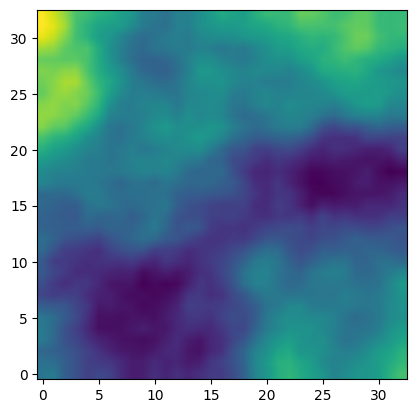

In [43]:
plt.imshow(np.mean(u_samps_0, axis=0), origin="lower", interpolation="bilinear")

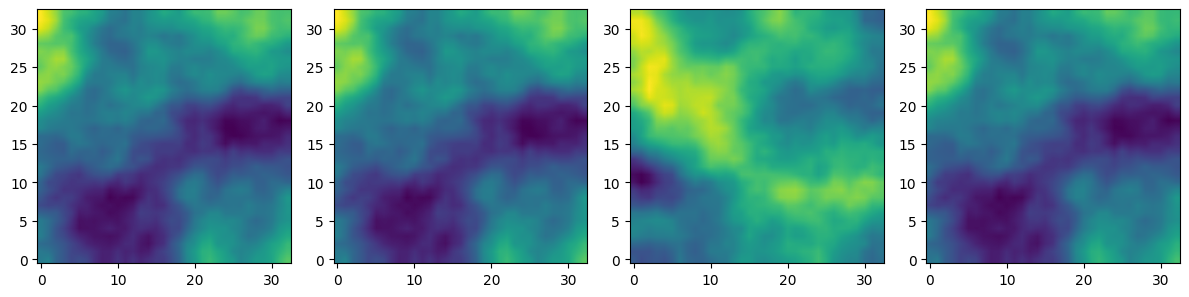

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(12,12))

for i in range(4):
    ax[i].imshow(u_samps_0[np.random.choice(nsamps), :, :], origin="lower", interpolation="bilinear")
plt.tight_layout()

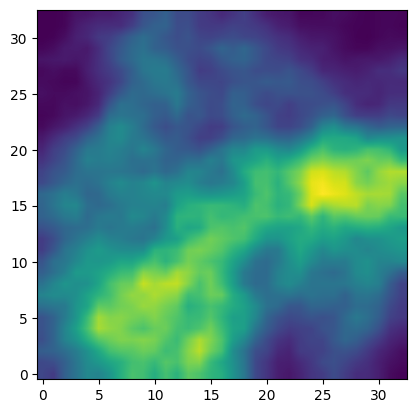

In [45]:
plt.imshow(np.var(u_samps_0, axis=0), origin="lower", interpolation="bilinear")

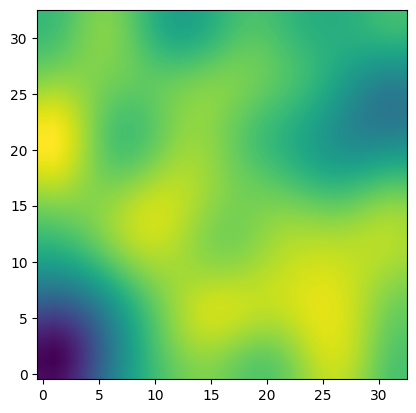

In [46]:
plt.imshow(np.mean(u_samps_1, axis=0), origin="lower", interpolation="bilinear")

In [47]:
mmd_array_nn

array([0.48889387, 0.00132394])